<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

FLAML offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/FLAML/docs/Use-Cases/Autogen#agents).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

FLAML requires `Python>=3.8`. To run this notebook example, please install flaml with the [autogen] option:
```bash
pip install flaml[autogen]
```

In [1]:
# %pip install flaml[autogen]~=2.0.1

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/FLAML/docs/reference/autogen/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [2]:
from flaml import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in FLAML to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [3]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To solve this task, we will need to do the following:

1. Get the current date: We can use Python's built-in datetime module to get the current date.

2. Get the year-to-date (YTD) gain for META (Facebook) and TESLA: We can use the yfinance module in Python to download the stock data. The YTD gain can be calculated as the percentage change in the closing price from the first trading day of the year to the most recent trading day.

Here is the Python code to perform these tasks:

```python
# python code
import datetime
import yfinance as yf

# Get the current date
today = datetime.date.today()
print("Today's date is:", today)

# Get the stock data for META and TESLA
meta = yf.Ticker("META")
tesla = yf.Ticker("TSLA")

# Get the historical market data
meta_hist = meta.history(period="

The example above involves code execution. In FLAML, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, FLAML defaults to the `flaml/autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto generated.

## Example Task: Plot Chart

In [4]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the year-to-date (YTD) stock price changes for META and TESLA and save it to a file, we can use the matplotlib library in Python. Here is the Python code to do this:

```python
# python code
# filename: plot_stock_price.py
import matplotlib.pyplot as plt

# Plot the closing prices of META and TESLA
plt.figure(figsize=(14, 7))
plt.plot(meta_hist['Close'], label='META')
plt.plot(tesla_hist['Close'], label='TESLA')
plt.title('Year-to-Date Stock Price Change for META and TESLA')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

# Save the plot to a file
plt.savefig('stock_price_ytd.png')
```

After running this Python code, a chart of the YTD stock price changes for META and TESLA will be saved to a file named 'stock_price_ytd.png'. 

Please make s

Let's display the generated figure.

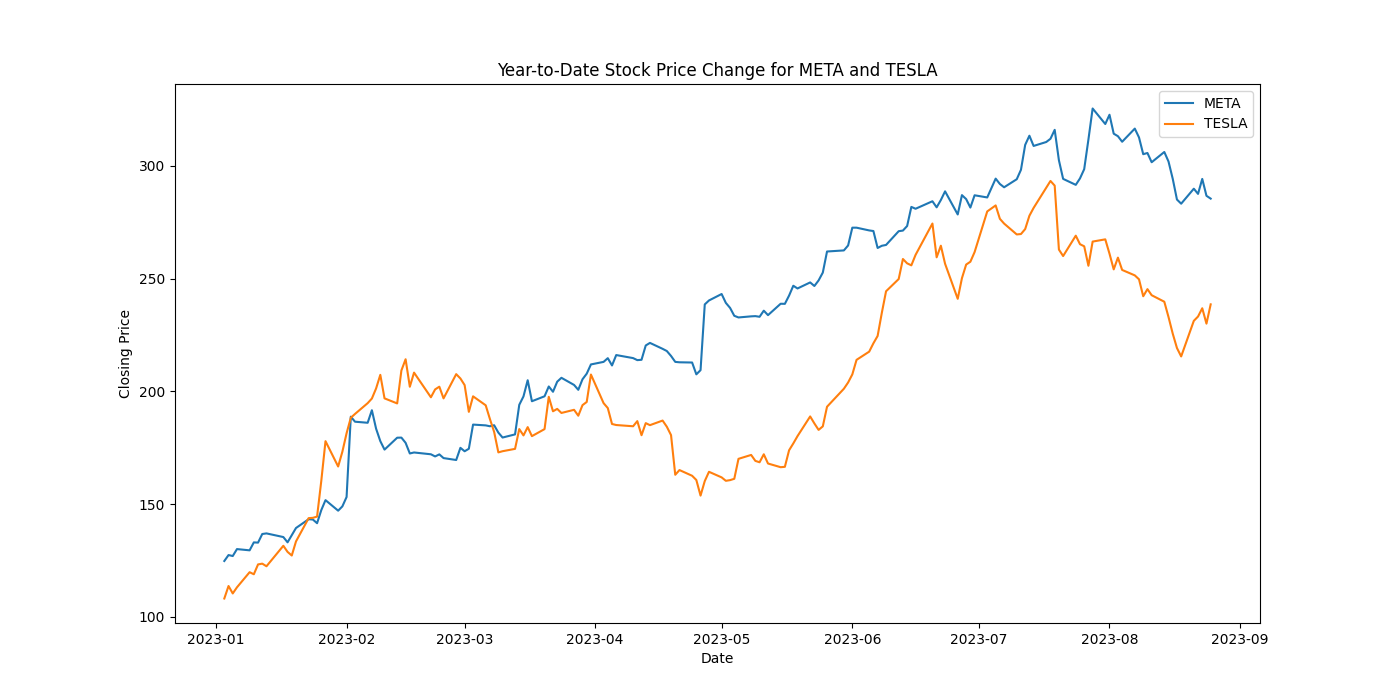

In [5]:
from IPython.display import Image

Image(filename='coding/stock_price_ytd.png')

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [6]:
from typing import Dict, Union
from IPython import get_ipython

class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return super().generate_init_message(*args, **kwargs) + """
If you suggest code, the code will be executed in IPython."""

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display plot directly.

ipython_user_proxy (to assistant):

What date is today? Plot a chart of META and TESLA stock price change YTD 2023
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

First, let's get the current date. We can use Python's built-in datetime module for this. Here is the Python code to get the current date:

```python
# python code
import datetime

# Get the current date
current_date = datetime.date.today()

print("Today's date is:", current_date)
```

Next, we need to plot a chart of META (Facebook's new name) and TESLA stock price change Year-To-Date (YTD) for the year 2023. However, as of now, we are not in the year 2023 yet, so we cannot get the YTD data for 2023. 

But, we can plot the YTD stock price change for the current year. We can use the yfinance module in Python to get the stock price data. If yfinance is not installed, it can be installed using pip:

`

SyntaxError: invalid syntax (2367222363.py, line 2)


>>>>>>>> EXECUTING CODE BLOCK 2 (inferred language is python)...


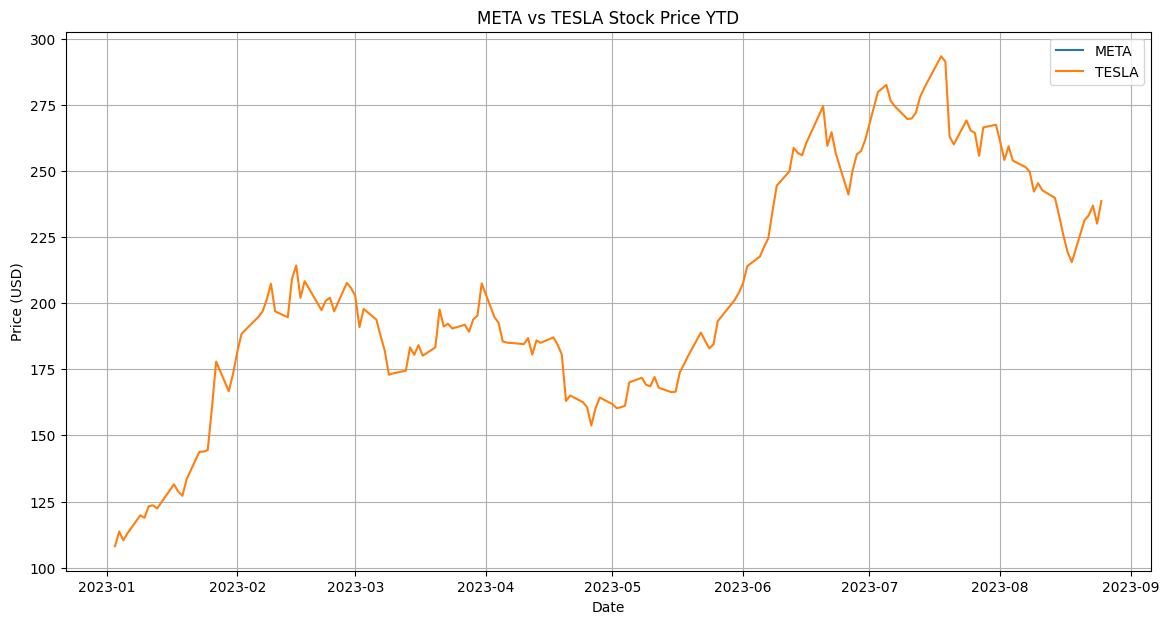

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
Today's date is: 2023-08-27


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

It seems like there was an issue with downloading the data for the 'FB' ticker symbol. This could be due to the fact that Facebook has changed its ticker symbol to 'META' recently. Let's try to download the data using the new ticker symbol 'META'. Here is the updated Python code:

```python
# python code
import yfinance as yf
import matplotlib.pyplot as plt

# Get the current year
current_year = datetime.date.today().year

# Get the YTD stock price data for META and TESLA
meta_data = yf.download('META', start=f'{current_year}-01-0

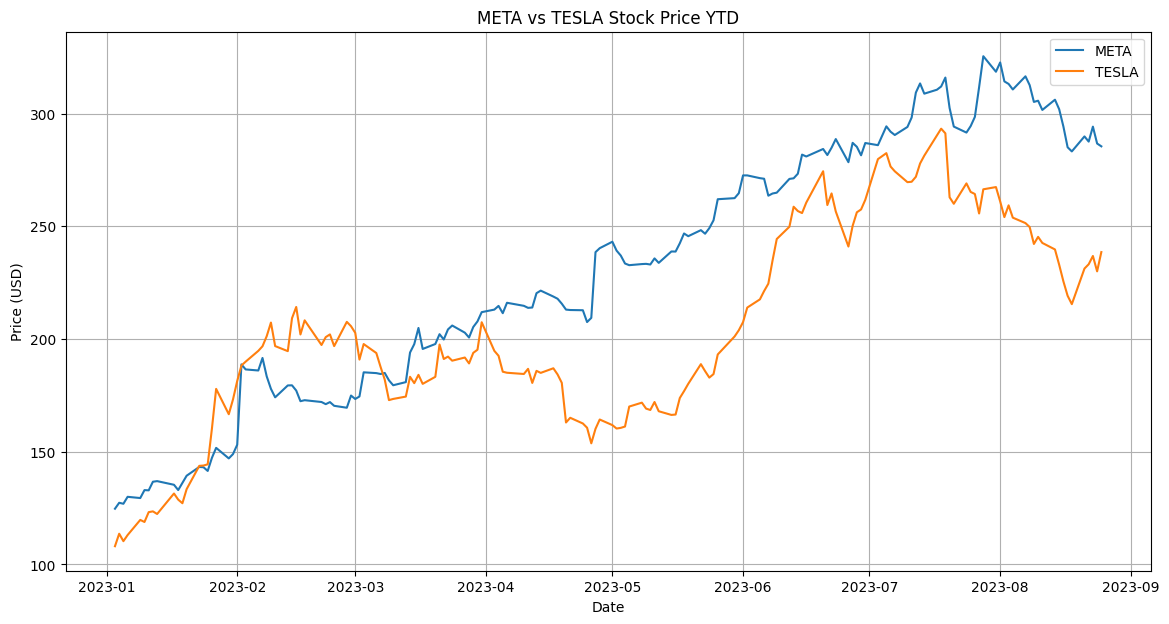

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

Great! The code has executed successfully. It should have downloaded the Year-To-Date (YTD) stock price data for META and TESLA for the current year and plotted it. The plot should show the closing prices of META and TESLA stocks over time. 

Please check the plot to see the stock price changes. If the plot is as expected, then the task is completed.

TERMINATE

--------------------------------------------------------------------------------


In [7]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""What date is today? Plot a chart of META and TESLA stock price change YTD 2023""",
)